# 1. Albumentations
* https://github.com/albumentations-team/albumentations
* 이미지를 쉽게 augmentation 해주는 파이썬 라이브러리
* 다양한 영상변환 알고리즘을 제공하고 있고, 처리속도도 매우 빨라 딥러닝 전처리용으로 많이 사용됨

In [1]:
# !pip install albumentations

  Using cached albumentations-1.1.0-py3-none-any.whl (102 kB)
     ---------------------------------------- 14.0/14.0 MB 9.2 MB/s eta 0:00:00
     ---------------------------------------- 34.1/34.1 MB 6.1 MB/s eta 0:00:00
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
     ---------------------------------------- 12.5/12.5 MB 8.5 MB/s eta 0:00:00
  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-win_amd64.whl (35.3 MB)
     -------------------------------------- 153.2/153.2 KB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 7.1/7.1 MB 10.6 MB/s eta 0:00:00
     -------------------------------------- 178.9/178.9 KB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 10.6 MB/s eta 0:00:00
     ---------------------------------------- 3.2/3.2 MB 10.9 MB/s eta 0:00:00
  Using cached imageio-2.16.1-py3-none-any.whl (3.3 MB)
     ---------------------------------------- 1.9/1.9 MB 10.2 MB/s eta 0:00:00
  Using cached joblib-1.1.0-py2

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [4]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 최대 8개의 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
            
    def __call__(self, **kwargs):
        if self.transform:
            augmented =self.transform(**kwargs)
            img = augmented['image']
            return img

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### https://github.com/tensorflow/models/issues/3134
        #### 파일 이슈 -> 삭제
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')            
            image = image / 255.
        
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        return batch_x, batch_y

In [7]:
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

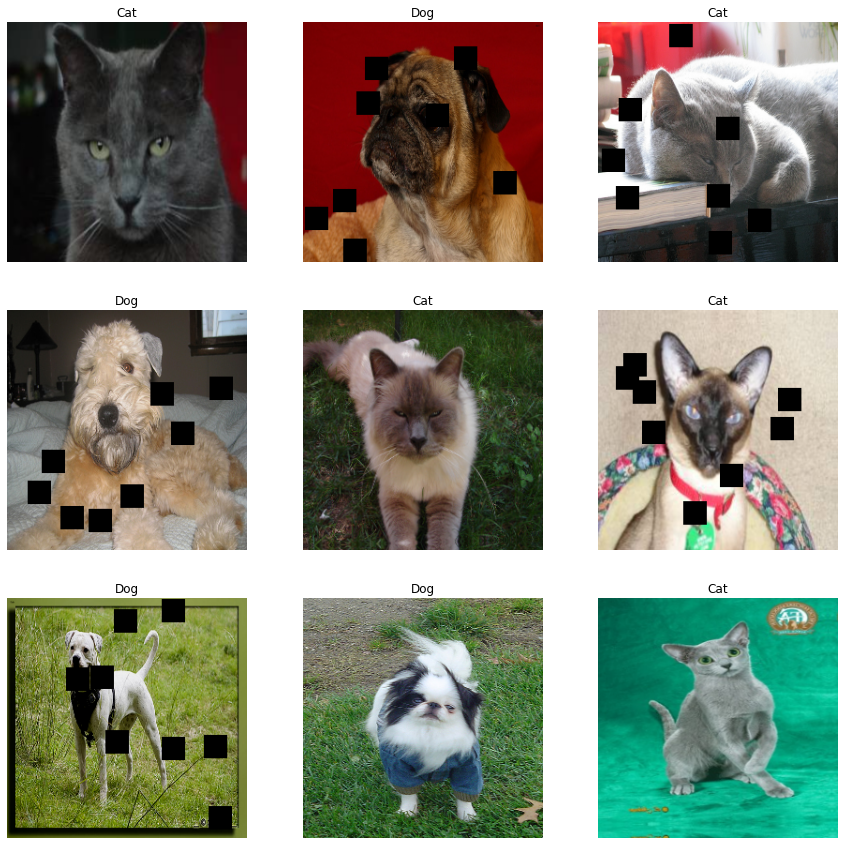

In [8]:
class_name = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    break
